In [1]:
# 設定超參數HyperParameters 
batch_size =  32
epochs = 30
image_size = 128
lr=0.005

## 一、載入相關套件

In [2]:
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils as np_utils
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2DTranspose

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-06-01 16:25:00.722989+08:00


## 製作標籤&資料集

In [6]:
csvfile = open('train.csv')
reader = csv.reader(csvfile)

In [7]:
# 讀取csv標籤
labels = []
for line in reader:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)
csvfile.close() 

In [8]:
# remove the first row
labels = labels[1:]
print("芒果圖片數量: ",len(labels))

芒果圖片數量:  5600


In [9]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("A","0")
    labels[i][1] = labels[i][1].replace("B","1")
    labels[i][1] = labels[i][1].replace("C","2")

In [10]:
# 隨機讀取圖片
a = 0
items= []
import random
for a in range(0,len(labels)):
    items.append(a)

In [11]:
# 製作訓練用資料集及標籤
# Wait for a while
X = []
y = []

for i in random.sample(items, round(len(items))):
    img = cv2.imread("C1-P1_Train/" + labels[i][0] )
    res = cv2.resize(img,(image_size,image_size),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    X.append(res)    
    y.append(labels[i][1])

In [12]:
# 轉換至array的格式
X = np.array(X)
y = np.array(y)

In [13]:
# 轉換至float的格式
for i in range(len(X)):
    X[i] = X[i].astype('float32')

In [14]:
# 標籤進行one-hotencoding
y = np_utils.to_categorical(y)

In [15]:
# 分配訓練集及測試集比例
x_train = X
y_train = y

## 建立Model

In [16]:
model_resnet = InceptionResNetV2(weights='imagenet', include_top=False)

input = Input( shape=(image_size,image_size,3),name = 'image_input' )
output_conv = model_resnet(input)

In [17]:
## 由於該問題是分 3 類，需要在最後修改 Dense(3)，softmax 代表 output 是機率  
#Add the fully-connected layers 
p = Flatten()(output_conv)
p = Dense(256,activation = 'relu')(p)
p = Dropout(0.2)(p)
p = Dense(3, activation='softmax', name='predictions')(p)

model = Model(inputs=input, outputs=p)

In [18]:
adam = optimizers.Adam(lr=lr)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [19]:
# model.summary()

## 訓練

In [20]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理

datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [21]:
# 導入圖像增強參數
datagen.fit(x_train)
# x_train = x_train/255
print('rescale！done!')

rescale！done!


In [22]:
# 檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [23]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [24]:
### Start Training
history = model.fit(
    datagen.flow(x_train , y_train, batch_size=batch_size),
    epochs = epochs
)

  ...
    to  
  ['...']
Train for 175 steps
Epoch 1/30
175/175 [==============================] - 59s 340ms/step - loss: 0.9002 - acc: 0.6452
Epoch 2/30
175/175 [==============================] - 36s 208ms/step - loss: 0.6548 - acc: 0.7105
Epoch 3/30
175/175 [==============================] - 37s 210ms/step - loss: 0.6291 - acc: 0.7275
Epoch 4/30
175/175 [==============================] - 37s 209ms/step - loss: 0.6235 - acc: 0.7204
Epoch 5/30
175/175 [==============================] - 37s 209ms/step - loss: 0.6393 - acc: 0.7155
Epoch 6/30
175/175 [==============================] - 37s 209ms/step - loss: 0.6291 - acc: 0.7161
Epoch 7/30
175/175 [==============================] - 37s 210ms/step - loss: 0.6132 - acc: 0.7280
Epoch 8/30
175/175 [==============================] - 37s 209ms/step - loss: 0.5938 - acc: 0.7441
Epoch 9/30
175/175 [==============================] - 37s 209ms/step - loss: 0.5772 - acc: 0.7434
Epoch 10/30
175/175 [==============================] - 37s 211ms/step - l

In [25]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-06-01 16:47:42.937247+08:00


(22, 42)

## 繪製Model學習成效

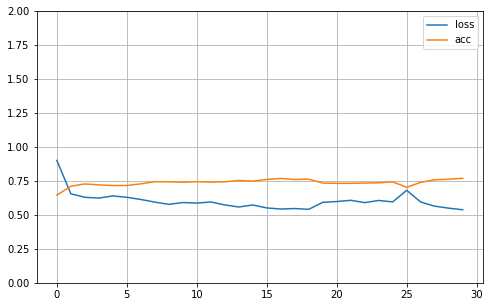

In [26]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
plot_learning_curves(history)

## 測試集預測準確度

In [27]:
csvfile_test = open('dev.csv')
reader_test = csv.reader(csvfile_test)

In [28]:
# 讀取csv標籤
labels = []
for line in reader_test:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)
csvfile_test.close() 

In [29]:
labels = labels[1:]  # remove the first row
print("芒果圖片數量: ",len(labels))

芒果圖片數量:  800


In [30]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("A","0")
    labels[i][1] = labels[i][1].replace("B","1")
    labels[i][1] = labels[i][1].replace("C","2")

In [31]:
x_test = []
y_test = []

for i in range(len(labels)):
    img = cv2.imread("C1-P1_Dev/" + labels[i][0] )
    res = cv2.resize(img,(image_size,image_size),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    x_test.append(res)    
    y_test.append(labels[i][1])

In [32]:
y_test_org = y_test

# 轉換至array的格式
x_test = np.array(x_test)
y_test = np.array(y_test)

In [33]:
# 轉換至float的格式
for i in range(len(x_test)):
    x_test[i] = x_test[i].astype('float32')
# x_test = x_test/255

In [34]:
# 標籤進行one-hotencoding
y_test = np_utils.to_categorical(y_test)

In [35]:
# 測試集標籤預測
y_pred = model.predict(x_test)

In [36]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[0 0 1 1 2 1 2 0 0 0 0 0 2 0 2 1 0 0 0 0 0 0 2 0 2 0 2 2 0 2 0 0 2 2 0 0 0
 0 0 0 0 2 0 0 2 2 1 0 2 0 1 0 1 2 2 0 1 0 2 0 0 0 2 2 0 2 2 0 2 2 2 1 1 2
 2 2 0 0 2 0 0 2 1 0 2 2 2 1 0 0 2 0 1 2 2 2 1 0 2 2 2 1 1 2 0 1 2 0 1 2 0
 0 2 0 0 2 2 2 1 0 1 0 2 0 2 1 0 2 2 1 0 0 2 1 0 2 2 1 0 2 0 2 2 0 0 0 2 0
 0 1 1 0 1 1 2 0 1 0 2 1 2 1 0 1 2 2 0 2 0 2 0 2 2 2 2 2 0 0 0 0 2 2 0 2 0
 2 0 2 2 2 2 2 1 0 2 0 0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 0 0 2 0 2 1 2 1 2 1 0
 0 1 0 2 0 0 0 2 2 0 1 2 0 0 2 0 2 0 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 1 1 2
 2 2 0 1 0 2 0 2 0 2 2 2 1 2 0 2 2 2 0 2 0 0 0 1 2 2 0 2 2 1 2 2 2 2 2 1 2
 0 1 0 2 2 0 2 0 2 2 2 2 1 2 2 0 2 1 0 2 0 1 1 0 2 1 2 2 2 0 0 2 0 2 0 0 2
 0 2 1 0 2 0 2 1 2 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 2 1 0 0 2 2 0 2 1 0 2 2 2
 2 2 2 2 0 2 0 2 0 2 0 0 0 1 0 2 1 2 0 2 2 2 1 2 1 0 2 2 0 0 0 0 2 2 0 2 0
 0 2 0 2 2 1 0 0 0 2 2 2 0 2 0 0 2 0 2 1 1 0 2 2 2 0 0 1 2 1 2 0 2 0 0 2 0
 0 0 0 1 0 1 2 2 2 2 0 0 0 0 0 1 2 0 2 2 0 1 0 0 0 0 1 2 2 2 0 2 2 0 2 2 0
 0 0 0 1 2 0 1 2 2 2 2 2 

In [37]:
# 模型原標籤
true_label = y_test_org
true_label = np.array(true_label)
print(true_label)
# print(len(true_label))

['1' '0' '1' '1' '2' '1' '2' '0' '1' '0' '0' '1' '2' '1' '2' '1' '1' '0'
 '0' '1' '0' '0' '2' '0' '1' '0' '2' '2' '1' '1' '1' '0' '2' '2' '0' '0'
 '0' '0' '0' '0' '1' '2' '0' '2' '2' '2' '1' '0' '2' '0' '1' '1' '1' '2'
 '2' '0' '1' '0' '2' '0' '1' '1' '2' '0' '1' '2' '2' '0' '2' '1' '2' '1'
 '1' '2' '2' '2' '1' '0' '2' '0' '0' '2' '1' '1' '2' '2' '2' '2' '0' '1'
 '2' '2' '1' '2' '2' '2' '1' '0' '2' '2' '2' '1' '1' '2' '1' '1' '1' '1'
 '1' '2' '2' '0' '1' '0' '0' '2' '2' '0' '2' '0' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '1' '0' '0' '0' '1' '0' '2' '1' '1' '0' '2' '0' '1' '2' '0'
 '0' '0' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '2' '1' '2' '0' '2' '1' '2' '2' '2' '2' '1' '0' '0' '0' '1'
 '2' '2' '0' '2' '1' '2' '0' '0' '2' '1' '2' '2' '1' '1' '2' '1' '0' '2'
 '1' '0' '2' '2' '1' '0' '1' '2' '0' '1' '2' '2' '2' '1' '1' '2' '0' '2'
 '1' '2' '1' '1' '0' '1' '1' '1' '1' '1' '0' '0' '1' '1' '0' '2' '1' '1'
 '0' '1' '2' '0' '2' '0' '1' '2' '2' '0' '1' '0' '2

In [38]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,216,9,18
1,118,102,73
2,9,6,249


In [39]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:70.88%


In [40]:
# 儲存模型相關參數
# model.save('h5/'+file_name+'.h5')